In [5]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import entropy


Duplicate key in file '/home/mdani31/semioLLM/visualization/.matplotlibrc', line 15 ('font.sans-serif      : Arial, sans-serif')
/tmp/ipykernel_364189/3838034953.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['ZS', 'FS', 'CoT', 'FS-CoT', 'SC'])


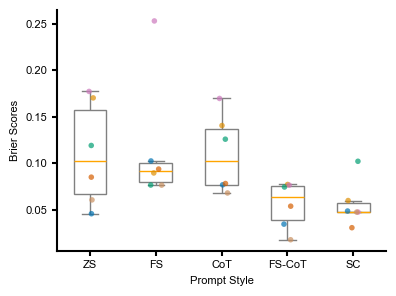

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import matplotlib as mpl
current_dir = os.path.dirname(os.path.abspath('__file__'))
format_file = os.path.join(current_dir, '.matplotlibrc')
with mpl.rc_context(fname=format_file):
# Data for Brier Scores
    brier_scores = {
        'Model': [
            'gpt-3.5-turbo-1106', 'gpt-4-1106-preview', 'mixtral-8x7b-instruct', 
            'qwen-72b', 'llama-v2-70b-chat', 'llama-v3-70B-instruct'
        ],
        'Zero-Shot': [0.046085, 0.170253, 0.119250, 0.085287, 0.177185, 0.060909],
        'Few-Shot': [0.102645, 0.089790, 0.076820, 0.093954, 0.252753, 0.076755],
        'CoT': [0.077054, 0.140619, 0.125987, 0.078457, 0.169653, 0.068321],
        'FewShot-CoT': [0.034923, 0.077435, 0.074697, 0.054161, 0.076720, 0.018193],
        'SC': [0.048981, 0.060211, 0.102299, 0.031092, 0.047842, 0.047827]
    }

    # Convert the data to a long-format DataFrame
    brier_df = pd.melt(
        pd.DataFrame(brier_scores),
        id_vars=['Model'], 
        var_name='Prompt Style', 
        value_name='Brier Score'
    )

    # Plot the boxplot
    plt.figure(figsize=(4, 3))
    sns.boxplot(
        x="Prompt Style", 
        y="Brier Score", 
        data=brier_df,
        showfliers=False,
        boxprops=dict(facecolor="none", edgecolor="gray"),
        whiskerprops=dict(color="gray"),
        capprops=dict(color="gray"),
        medianprops=dict(color="orange"),
        width=0.5
    )

    # Add a strip plot for individual data points
    ax = sns.stripplot(
        x="Prompt Style", 
        y="Brier Score", 
        data=brier_df, 
        hue="Model",
        palette='colorblind', 
        size=4, 
        jitter=True, 
        alpha=0.7
    )
    #ax.legend(bbox_to_anchor=(1.0, 0.89), loc='upper left')
    ax.get_legend().remove()

    # Add labels, title, and grid
    #plt.xlabel("Prompt Style")
    plt.ylabel('Brier Scores')
    ax.set_xticklabels(['ZS', 'FS', 'CoT', 'FS-CoT', 'SC'])
    #plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    #plt.savefig('brier_scores_boxplot.svg')
    # Show the plot
    plt.show()


# reliability diagram

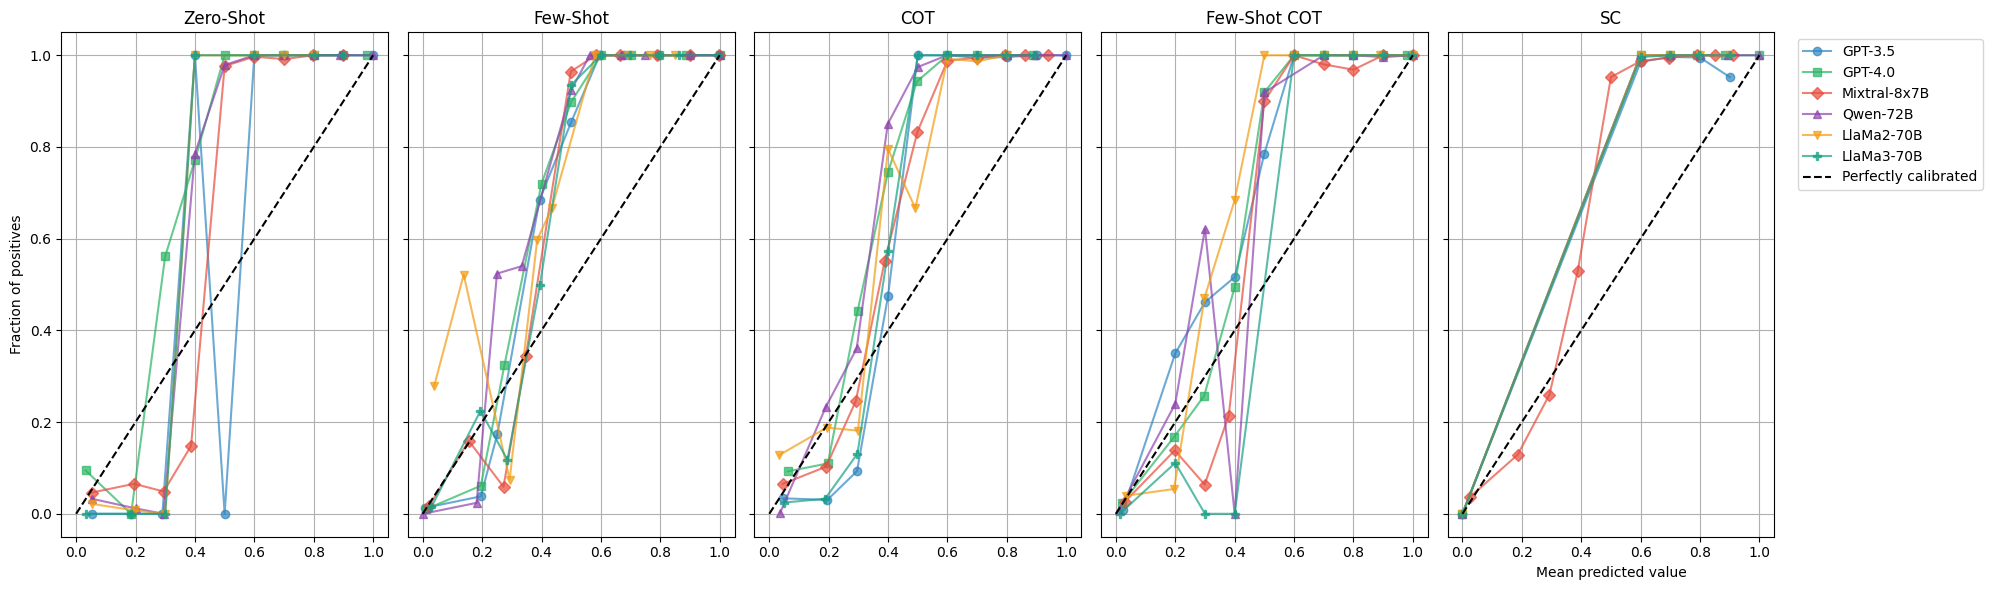

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import pandas as pd
import os
from scipy.special import softmax

# Define the models and prompt strategies
models = ['gpt-3.5-turbo-1106', 'gpt-4-1106-preview', 'mixtral-8x7b-instruct', 'qwen-72b', 'llama-v2-70b-chat','llama-v3-70B-instruct']
prompt_strategies = ['zero-shot', '5-shot', 'zs-cot', 'fs-cot', 'sc-cot']
likelihood_dir = '/shared-local/mdani31/semio_result/evaluation_res/likelihood_arr'
label_csv = '/shared-local/mdani31/semio_result/evaluation_res/model_labels_nature.csv'

strategy_mapping = {
    'zero-shot': 'Zero-Shot',
    '5-shot': 'Few-Shot',
    'zs-cot': 'COT',
    'fs-cot': 'Few-Shot COT',
    'sc-cot': 'SC'
}

model_mapping = {  
    'gpt-3.5-turbo-1106': 'GPT-3.5',
    'gpt-4-1106-preview': 'GPT-4.0',
    'mixtral-8x7b-instruct': 'Mixtral-8x7B',
    'qwen-72b': 'Qwen-72B',
    'llama-v2-70b-chat': 'LlaMa2-70B',
    'llama-v3-70B-instruct': 'LlaMa3-70B'
}
# Load the label CSV
output_label_df = pd.read_csv(label_csv)

# Define 6 colors and markers for 6 different models
colors = ['#2E86C1', '#28B463', '#E74C3C', '#8E44AD', '#F39C12', '#16A085']
markers = ['o', 's', 'D', '^', 'v', 'P']
line_styles = ['-', '--', '-.', ':', '-', '--']

# Create subplots for each prompt strategy
n_strategies = len(prompt_strategies)
fig, axes = plt.subplots(1, n_strategies, figsize=(20, 6), sharey=True)

# Iterate over each prompt strategy
count = 1
for strategy_idx, strategy in enumerate(prompt_strategies):
    ax = axes[strategy_idx]  # Get the axis for the current strategy
    ax.set_title(f'{strategy_mapping[strategy]}', fontsize=12)
    #ax.set_title(f'{strategy}', fontsize=12)

    # Iterate over each model
    for model_idx, model in enumerate(models):
        # Load the likelihoods array from the .npy file
        if strategy == '5-shot' and model in ['gpt-4-1106-preview', 'gpt-3.5-turbo-1106']:
            npy_file = os.path.join(likelihood_dir, f'{model}_few-shot_likelihood.npy')
        else:
            npy_file = os.path.join(likelihood_dir, f'{model}_{strategy}_likelihood.npy')
        if not os.path.exists(npy_file):
            print(f"File {npy_file} not found.")
            continue
        likelihoods_array = np.load(npy_file)
        # Assuming output_label_df is already defined and has the same length as likelihoods_array
        n_samples = len(output_label_df)
        #compute how many likelihoods have all zeros and remove them from n_samples
        #n_samples = n_samples - np.count_nonzero(np.sum(likelihoods_array, axis=1) == 0)
        count += 1
        #continue
        # Initialize arrays to store values
        pred_probas = np.zeros(n_samples)
        confidence_scores = np.zeros(n_samples)
        predicted_classes = np.zeros(n_samples, dtype=int)
        ground_truths = np.zeros(n_samples, dtype=int)
        correctness = np.zeros(n_samples, dtype=int)

        # Populate the arrays
        valid_indices = []
        for index, row in output_label_df.iterrows():
            predicted_class = row[f'{model}_{strategy}']
            ground_truth = row['True_labels']
            # Get binary correctness (1 if prediction is correct, 0 if incorrect)
            correct = (predicted_class == ground_truth).astype(int)
            # Use the likelihood of the ground truth class as confidence
            #confidence = likelihoods_array[index, ground_truth - 1]  # Assuming ground_truth is 1-based 
            #pred_proba = likelihoods_array[index, predicted_class - 1]  #as likelihoods begin from 0
            #ignore the case where the likelihoods are all 0 and do not include output_label_df for that index also
            if likelihoods_array[index].sum() == 0:
                continue
            # if likelihoods_array[index].sum() == 0:
            #     confidence_score = 0.0
            else:
                valid_indices.append(index)
                pred_proba = likelihoods_array[index, ground_truth - 1]  #as likelihoods begin from 0
                #pred_proba = likelihoods_array[index, predicted_class - 1]  #as likelihoods begin from 0
                confidence_score = compute_confidence_score(likelihoods_array[index])
            
            # Store values in arrays
            pred_probas[index] = pred_proba/100 #divide all likelihoods by 100 to get the probability
            #pred_probas[index] = pred_probas[index]/100
            predicted_classes[index] = predicted_class
            ground_truths[index] = ground_truth
            correctness[index] = correct
            confidence_scores[index] = confidence_score

        # Filter arrays to include only valid rows
        valid_indices = np.array(valid_indices)
        pred_probas = pred_probas[valid_indices]
        confidence_scores = confidence_scores[valid_indices]
        correctness = correctness[valid_indices]
        #print(f'length of pred_probas post filtering valid indices: {len(pred_probas)}')
        #plot confidence score vs predicted probability
        #arramge the data in ascending order of predicted probability
        sorted_idx = np.argsort(pred_probas)
        confidence_scores = confidence_scores[sorted_idx]
        pred_probas = pred_probas[sorted_idx]
        correctness = correctness[sorted_idx]
        #print(sorted_idx)
        #ax.scatter(confidence_scores, pred_probas, marker=markers[model_idx], color=colors[model_idx], label=f'{model}')
        #also add a calibration curve between confidence score and fraction of correct predictions
        #print(correctness, confidence_scores)
        #fraction_of_positives, mean_predicted_value = calibration_curve(correctness, confidence_scores, n_bins=10)
        fraction_of_positives, mean_predicted_value = calibration_curve(correctness, pred_probas, n_bins=10, strategy='uniform')
        ax.plot(mean_predicted_value, fraction_of_positives, marker=markers[model_idx], color=colors[model_idx], label=f'{model_mapping[model]}', alpha=0.7)
        # Compute the Brier score
        brier_score = brier_score_loss(correctness, pred_probas)
        #print(f'Brier score for {model} and {strategy} is {brier_score}')
        #Compute the ECE
        # Add to your existing code after computing Brier score:
        ece = compute_ece(correctness, pred_probas)
        #print(f'ECE for {model} and {strategy} is {ece:.4f}')

    # Plot the perfectly calibrated line
    ax.plot([0, 1], [0, 1], linestyle='--', color='k', label='Perfectly calibrated')

    # Set labels for x and y axes
    #ax.set_xlabel('Confidence Score')
    if strategy_idx == 0:
        ax.set_ylabel('Fraction of positives')

    # Add legend outside the plot for the first subplot only
    if strategy_idx == n_strategies - 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move the legend outside the last plot
    ax.grid(True)

# Adjust layout to fit all subplots
#give common x and y labels
plt.xlabel('Mean predicted value')
plt.tight_layout()
#plt.savefig('calibration_curve.svg', format='svg', dpi=600)
plt.show()

